# Data Acquisition
### Data was garthered from Kaggle and unsplash.com. Then the specified number of images was hand selected.

In [2]:
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import Input, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Also download best model

!wget 'https://www.dropbox.com/scl/fo/exictz48hl0f2dgxnhxyu/AB5X7HYo_ailNXAkK1GImCo?rlkey=yeij64l7spheyc4k7krylvek1&st=na5tgkfe&dl=0'
!wget 'https://www.dropbox.com/scl/fi/jpx02l5fa9a92t6b77keo/MT_NHF_0_81.keras?rlkey=zhztu6y2xjrvjs2m3atv73ki2&st=dvrexlfb&dl=0'
!unzip 'AB5X7HYo_ailNXAkK1GImCo?rlkey=yeij64l7spheyc4k7krylvek1&st=na5tgkfe&dl=0'

old_file_name = "MT_NHF_0_81.keras?rlkey=zhztu6y2xjrvjs2m3atv73ki2&st=dvrexlfb&dl=0"
new_file_name = "MT_NHF_0_81.keras"
os.rename(old_file_name, new_file_name)

--2024-12-05 11:48:57--  https://www.dropbox.com/scl/fo/exictz48hl0f2dgxnhxyu/AB5X7HYo_ailNXAkK1GImCo?rlkey=yeij64l7spheyc4k7krylvek1&st=na5tgkfe&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7ce47a3ba31d74f219ae0ce540.dl.dropboxusercontent.com/zip_download_get/CDEYikvqGIexHrmIEPbX2qCGgyuHs074DNV-kfDSxXJ5lrL4HiVc5Mdaum4w0lM6L76b0odI-_HBYYtNUK6ooTj-KxiuzP62xynl3iD4xblnjQ# [following]
--2024-12-05 11:48:58--  https://uc7ce47a3ba31d74f219ae0ce540.dl.dropboxusercontent.com/zip_download_get/CDEYikvqGIexHrmIEPbX2qCGgyuHs074DNV-kfDSxXJ5lrL4HiVc5Mdaum4w0lM6L76b0odI-_HBYYtNUK6ooTj-KxiuzP62xynl3iD4xblnjQ
Resolving uc7ce47a3ba31d74f219ae0ce540.dl.dropboxusercontent.com (uc7ce47a3ba31d74f219ae0ce540.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to uc7ce47a3ba31d74f219a

# Data Cleansing

In [4]:
# Safely load images with error handling
def load_images_from_folder(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            try:
                img = Image.open(file_path)
                image_list.append(img)
            except (IOError) as e:
                print(f"Error loading image {filename}: {e}")
    return image_list

# Load the classes to lists with error handling for corrupted images
books_orig_size = load_images_from_folder('books')
shoes_orig_size = load_images_from_folder('shoes')
chairs_orig_size = load_images_from_folder('chairs')
fridges_orig_size = load_images_from_folder('fridges')
tables_orig_size = load_images_from_folder('tables')

Error loading image Intentional_error.txt: cannot identify image file '/content/books/Intentional_error.txt'


### Display Images
### Dispaly some images to test if proper loading.

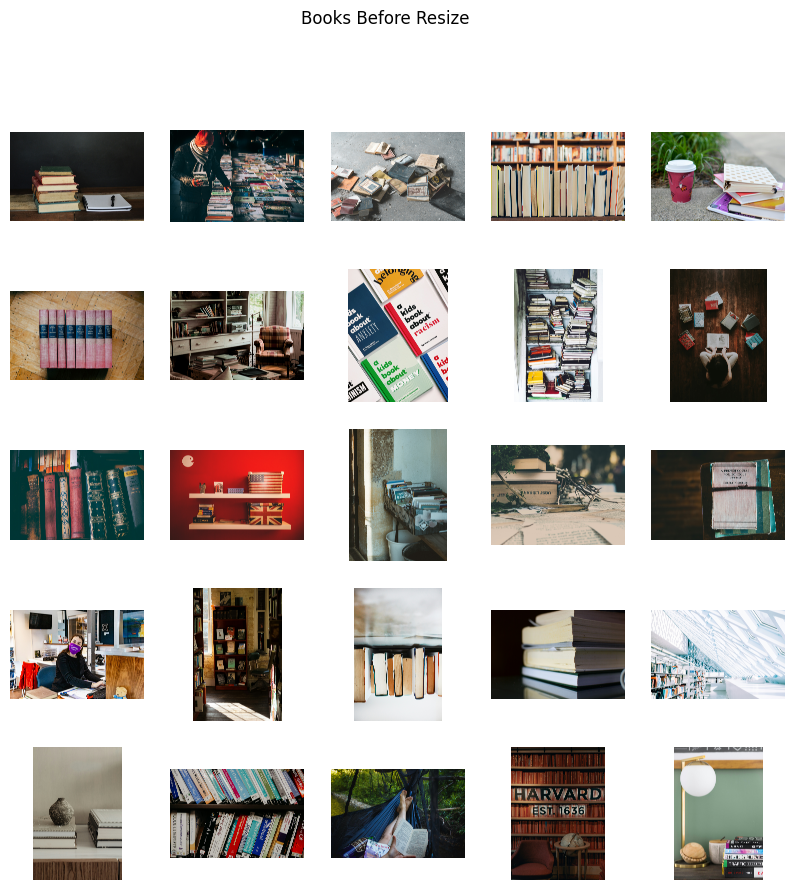

In [4]:
def display_images_from_list(images, title, labels=None):
    if labels:
        combined = list(zip(images, labels))
        random.shuffle(combined)
        images, labels = zip(*combined)
    else:
        labels = [None] * len(images)

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.suptitle(title)

    for i, (ax, img) in enumerate(zip(axes.flatten(), images[:25])):
        ax.imshow(img)
        if labels:
            ax.set_title(labels[i], fontsize=8)
        ax.axis('off')

    plt.show()

display_images_from_list(books_orig_size, 'Books Before Resize')

## Image Resize
### Resize images to 256 x 256 for better performance. Also return the appropriate label for the image.

In [5]:
def Img_Resize(image_list, image_type, output_size=(256, 256)):
    output_size = (256, 256) # New size of images
    # Labels for classes
    type_dict = {'book': 'book', 'chair': 'furniture', 'table': 'furniture', 'fridge': 'furniture', 'shoe': "shoe"}
    labels = {f"{image_type}_{i}": type_dict[image_type] for i in range(1, len(image_list) + 1)}
    resized_images = []

    for img in image_list:
        try:
            resized_img = img.resize(output_size)
            resized_images.append(resized_img)
        except Exception as e:
            print(f"Error resizing image: {e}")

    return resized_images, labels

# Instantiate resized images and labels
books, books_labels = Img_Resize(books_orig_size, 'book')
books, books_labels = books[:50], dict(itertools.islice(books_labels.items(), 50))

shoes, shoes_labels = Img_Resize(shoes_orig_size, 'shoe')
shoes, shoes_labels = shoes[:50], dict(itertools.islice(shoes_labels.items(), 50))

chairs, chairs_labels = Img_Resize(chairs_orig_size, 'chair')
chairs, chairs_labels = chairs[:17], dict(itertools.islice(chairs_labels.items(), 17))

fridges, fridges_labels = Img_Resize(fridges_orig_size, 'fridge')
fridges, fridges_labels = fridges[:16], dict(itertools.islice(fridges_labels.items(), 16))

tables, tables_labels = Img_Resize(tables_orig_size, 'table')
tables, tables_labels = tables[:17], dict(itertools.islice(tables_labels.items(), 17))

# Update Furniture list
# It is a combination of chairs, fridges and tables
furniture = chairs + fridges + tables
furniture_labels = {}
furniture_labels.update(chairs_labels)
furniture_labels.update(fridges_labels)
furniture_labels.update(tables_labels)

### Test Furniture label correctness

In [7]:
print(furniture_labels)

{'chair_1': 'furniture', 'chair_2': 'furniture', 'chair_3': 'furniture', 'chair_4': 'furniture', 'chair_5': 'furniture', 'chair_6': 'furniture', 'chair_7': 'furniture', 'chair_8': 'furniture', 'chair_9': 'furniture', 'chair_10': 'furniture', 'chair_11': 'furniture', 'chair_12': 'furniture', 'chair_13': 'furniture', 'chair_14': 'furniture', 'chair_15': 'furniture', 'chair_16': 'furniture', 'chair_17': 'furniture', 'fridge_1': 'furniture', 'fridge_2': 'furniture', 'fridge_3': 'furniture', 'fridge_4': 'furniture', 'fridge_5': 'furniture', 'fridge_6': 'furniture', 'fridge_7': 'furniture', 'fridge_8': 'furniture', 'fridge_9': 'furniture', 'fridge_10': 'furniture', 'fridge_11': 'furniture', 'fridge_12': 'furniture', 'fridge_13': 'furniture', 'fridge_14': 'furniture', 'fridge_15': 'furniture', 'fridge_16': 'furniture', 'table_1': 'furniture', 'table_2': 'furniture', 'table_3': 'furniture', 'table_4': 'furniture', 'table_5': 'furniture', 'table_6': 'furniture', 'table_7': 'furniture', 'table_8

# Display Images with assigned Labels

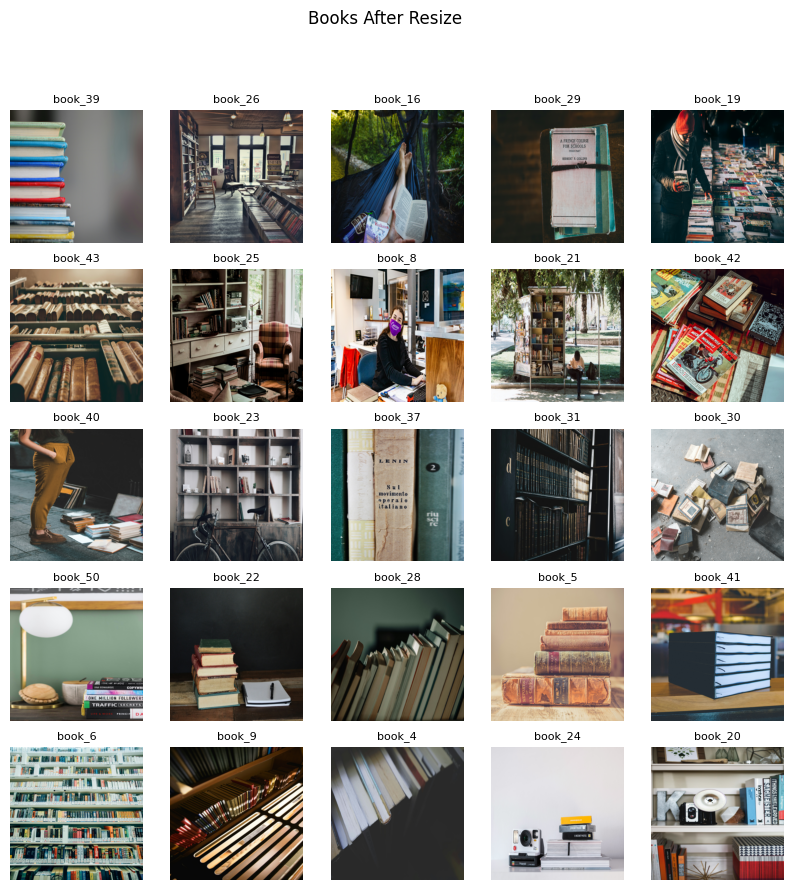

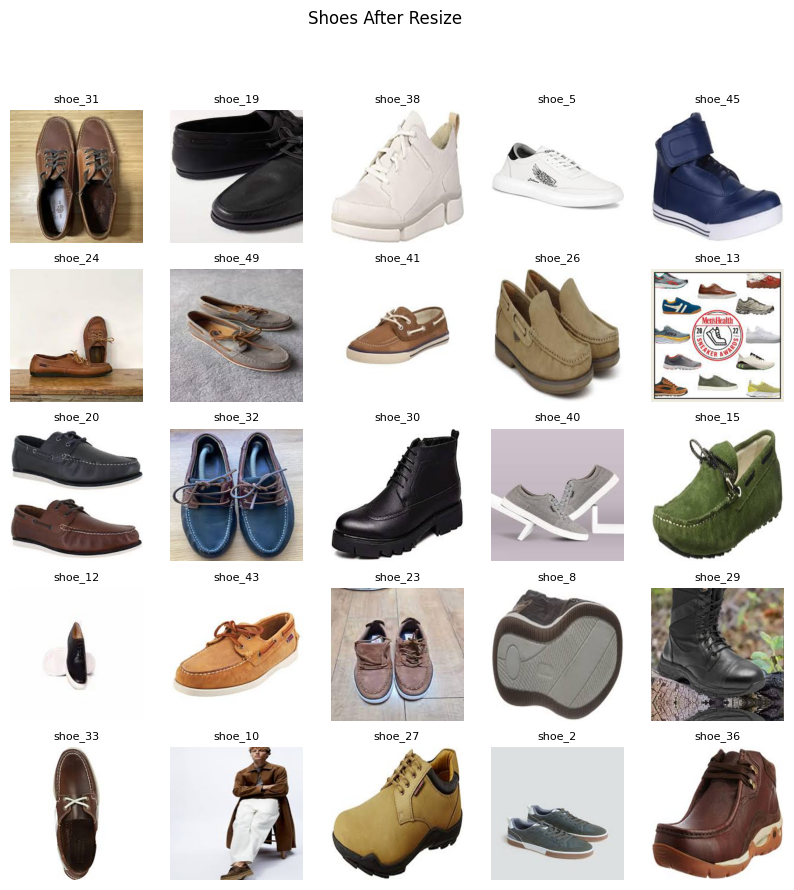

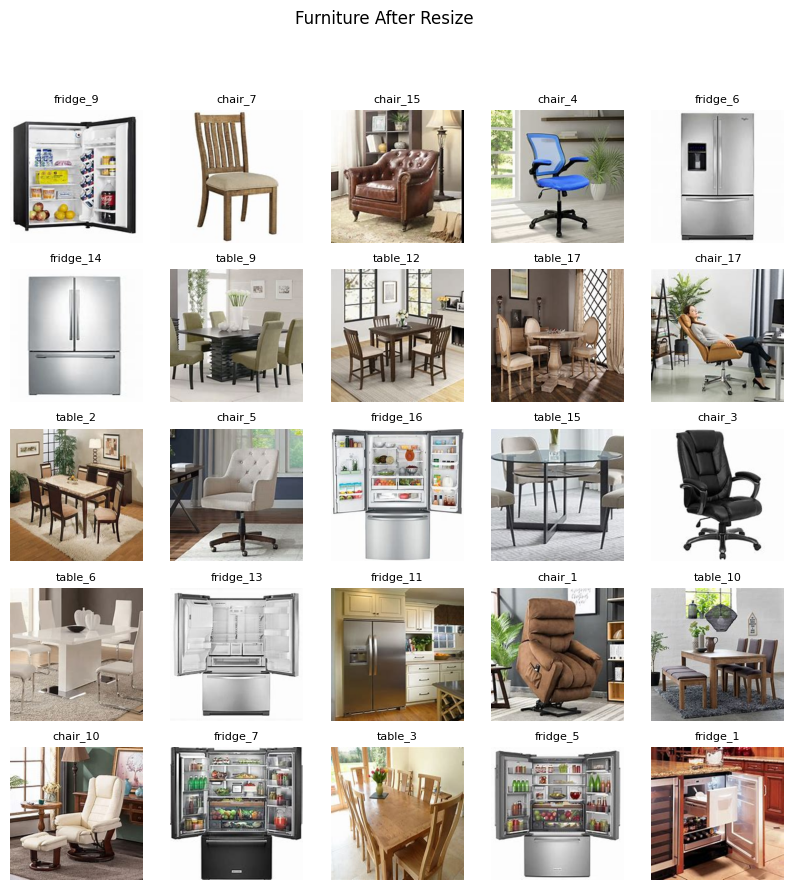

In [ ]:
display_images_from_list(books, 'Books After Resize', books_labels)
display_images_from_list(shoes, 'Shoes After Resize', shoes_labels)
display_images_from_list(furniture, 'Furniture After Resize', furniture_labels)

### Count the number of items in each class
#### Combine the data to make a pie chart

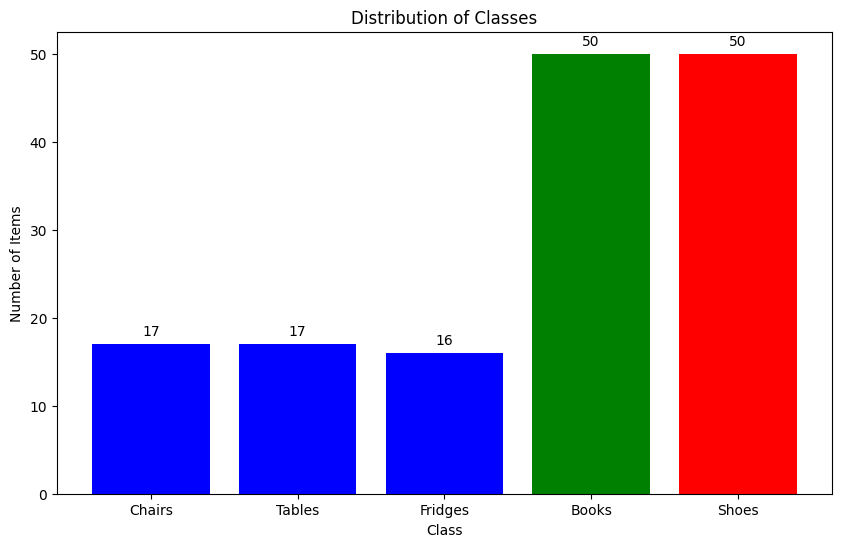

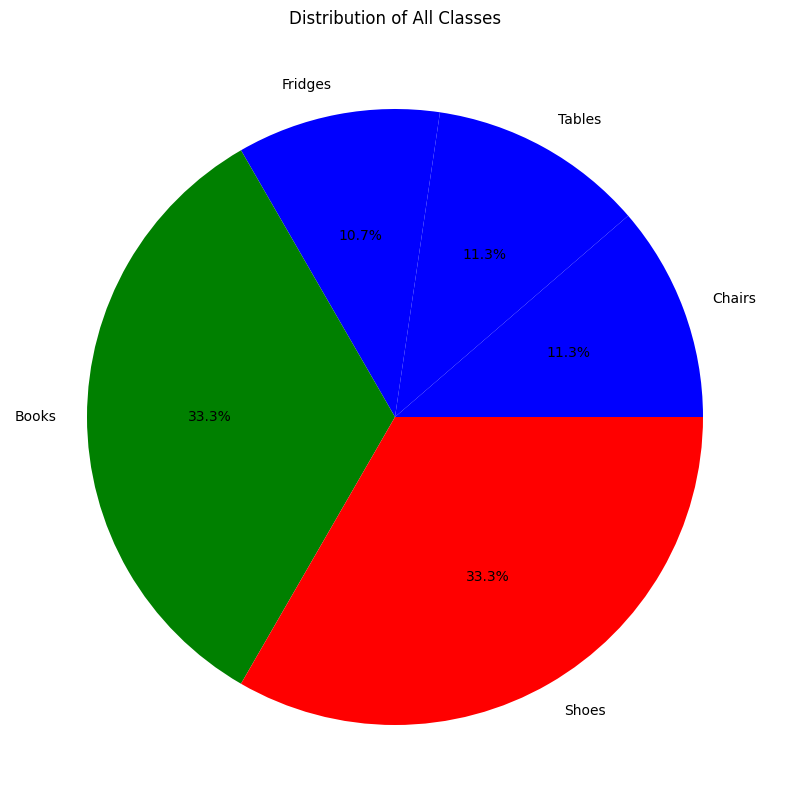

In [9]:
all_counts = {
    'Chairs': len(chairs),
    'Tables': len(tables),
    'Fridges': len(fridges),
    'Books': len(books),
    'Shoes': len(shoes)
}

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(all_counts.keys(), all_counts.values(), color=['blue', 'blue', 'blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(all_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes')
plt.figure(figsize=(10, 10))
plt.pie(all_counts.values(), labels=all_counts.keys(), autopct='%1.1f%%', colors=['blue', 'blue', 'blue', 'green', 'red'])
plt.title('Distribution of All Classes')
plt.show()

# Data Preparation
### Split data into train, validation and test sets. Test and Validation set size is 14%, which is 21 images. This is significant because this way we have an equal number of images from each class while having a big enough test and validation dataset size.

In [6]:
# Convert data to the correct format
all_images = furniture + shoes + books
all_labels_list = list(furniture_labels.values()) + list(shoes_labels.values()) + list(books_labels.values())

# Since data is ordered this creates 3 arrays, each with one type of image (book, furniture or shoe)
classes = np.array_split(all_images, 3)
labels = np.array_split(all_labels_list, 3)

# Set train,test and val counts per class
num_test, num_val = 7, 7
num_train = 50 - num_test - num_val

# Create the splits
train_images = sum([list(cls[:num_train]) for cls in classes], [])
train_labels = sum([list(lbl[:num_train]) for lbl in labels], [])
val_images = sum([list(cls[num_train:num_train + num_val]) for cls in classes], [])
val_labels = sum([list(lbl[num_train:num_train + num_val]) for lbl in labels], [])
test_images = sum([list(cls[num_train + num_val:]) for cls in classes], [])
test_labels = sum([list(lbl[num_train + num_val:]) for lbl in labels], [])

# Randomize train data, since we didn't use train_test_split
# This step helps the model generalize better
combined = list(zip(train_images, train_labels))
random.seed(3)
random.shuffle(combined)
train_images, train_labels = zip(*combined)
train_images = list(train_images)
train_labels = list(train_labels)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 108
Validation set size: 21
Test set size: 21


### Data Statistics

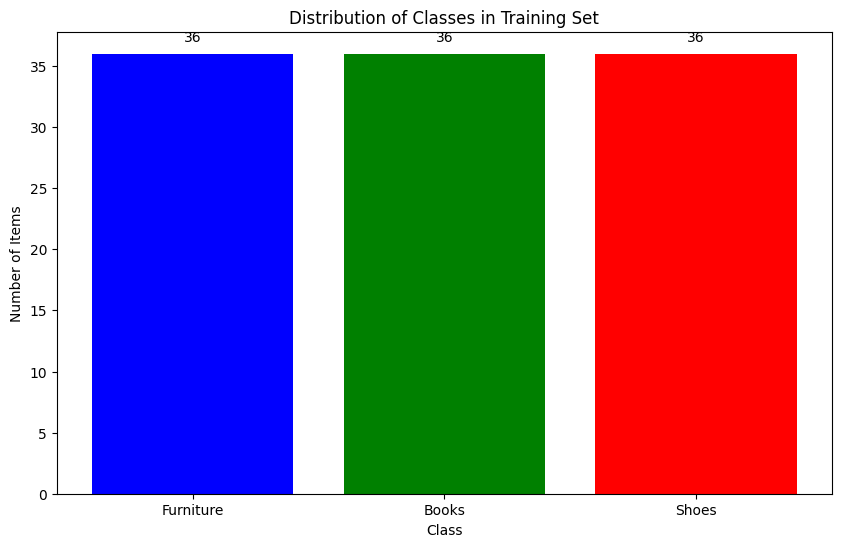

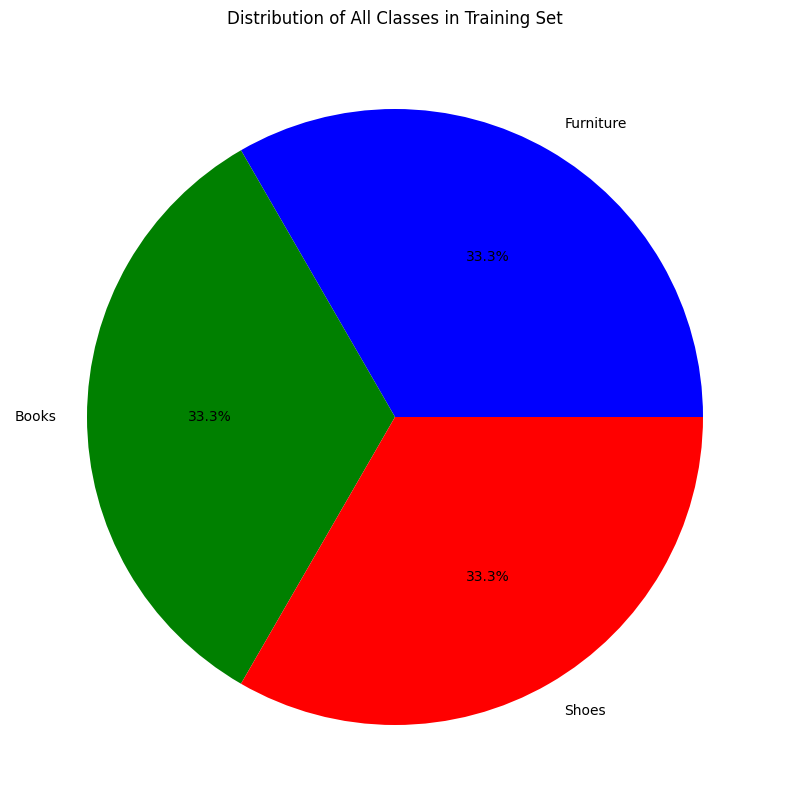

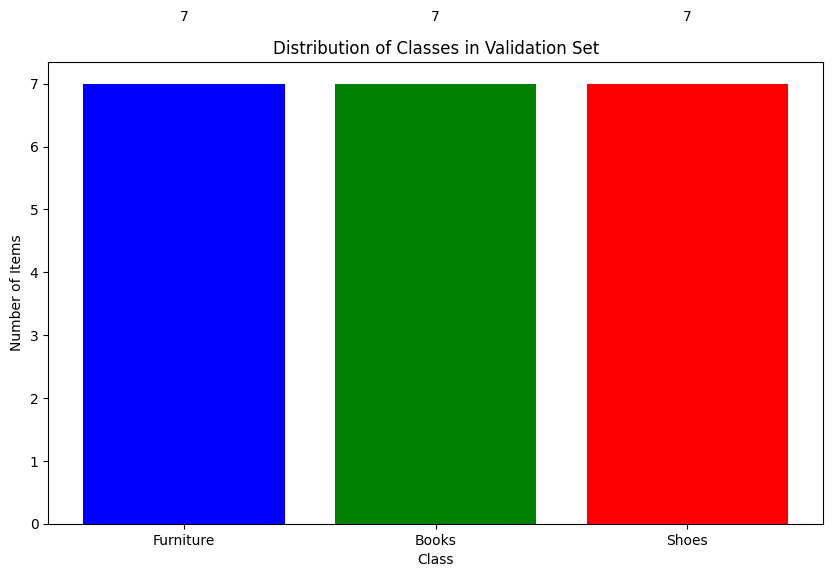

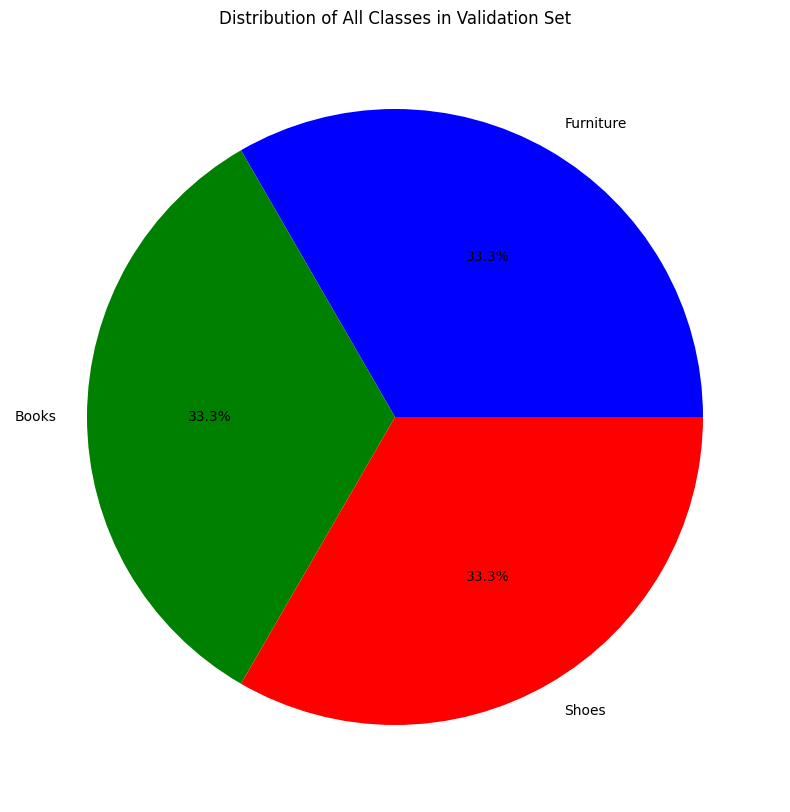

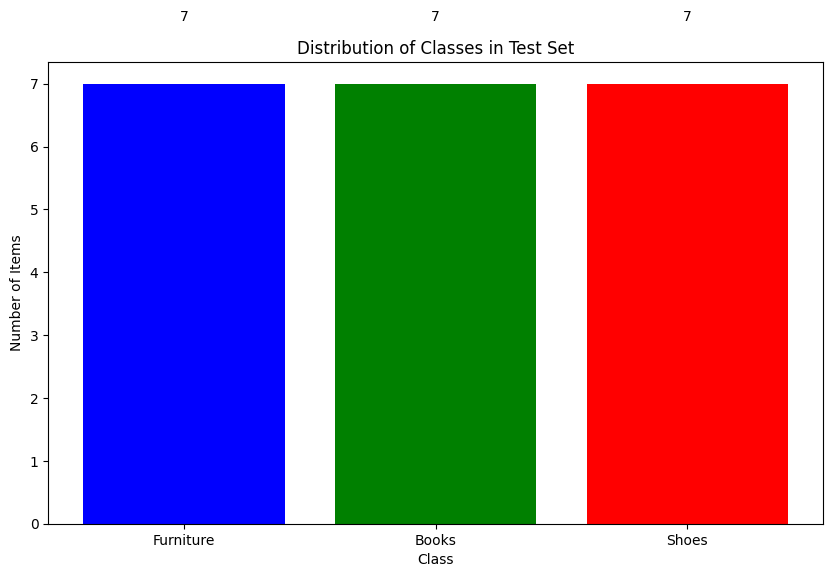

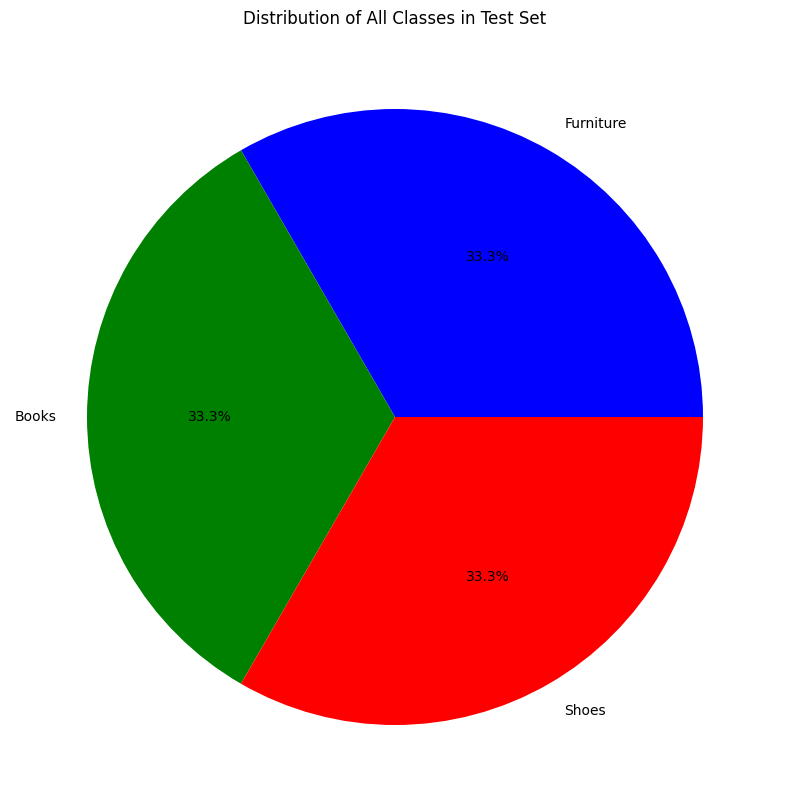

In [23]:
train_counts = {
    'Furniture': sum(1 for label in train_labels if label == 'furniture'),
    'Books': sum(1 for label in train_labels if label == 'book'),
    'Shoes': sum(1 for label in train_labels if label == 'shoe')
}

# Plot the distribution for the training set
plt.figure(figsize=(10, 6))
plt.bar(train_counts.keys(), train_counts.values(), color=['blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(train_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes in Training Set')
plt.figure(figsize=(10, 10))
plt.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Distribution of All Classes in Training Set')
plt.show()

# Count the number of items in each class in the validation set
val_counts = {
    'Furniture': sum(1 for label in test_labels if label == 'furniture'),
    'Books': sum(1 for label in test_labels if label == 'book'),
    'Shoes': sum(1 for label in test_labels if label == 'shoe')
}

# Plot the distribution for the validation set
plt.figure(figsize=(10, 6))
plt.bar(val_counts.keys(), val_counts.values(), color=['blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(val_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes in Validation Set')
plt.figure(figsize=(10, 10))
plt.pie(val_counts.values(), labels=val_counts.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Distribution of All Classes in Validation Set')
plt.show()

# Count the number of items in each class in the test set
test_counts = {
    'Furniture': sum(1 for label in test_labels if label == 'furniture'),
    'Books': sum(1 for label in test_labels if label == 'book'),
    'Shoes': sum(1 for label in test_labels if label == 'shoe')
}

# Plot the distribution for the test set
plt.figure(figsize=(10, 6))
plt.bar(test_counts.keys(), test_counts.values(), color=['blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(test_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes in Test Set')
plt.figure(figsize=(10, 10))
plt.pie(test_counts.values(), labels=test_counts.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Distribution of All Classes in Test Set')
plt.show()

# Baseline models

##Random choosing
### This model chooses an output randomly, each class having a chance of 33.3%. For better representaion we predict the labels of the training set.

Accuracy: 0.39



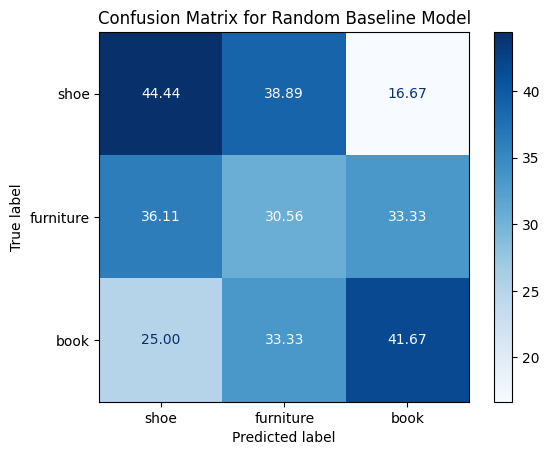

In [27]:
classes = list(set(val_labels))
num_samples = len(train_images)

# Retrun random predictions for every image of the set
def random_baseline_predictions(num_samples):
    return [random.choice(classes) for _ in range(num_samples)]

true_labels = train_labels
random_predictions = random_baseline_predictions(num_samples)

# Convert the random predictions and true labels to arrays for evaluation
random_predictions_array = np.array(random_predictions)
true_labels_array = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels_array, random_predictions_array)
print(f"Accuracy: {accuracy:.2f}\n")

# Confusion matrix
conf_matrix = confusion_matrix(true_labels_array, random_predictions_array, labels=classes)
conf_matrix_percent = np.nan_to_num(conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title('Confusion Matrix for Random Baseline Model')
plt.show()

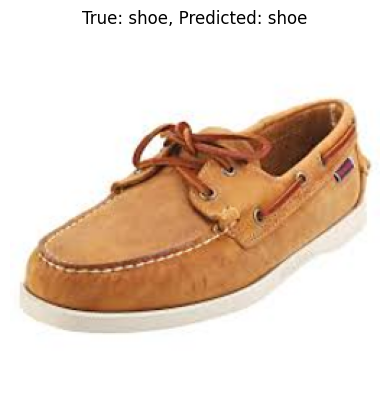

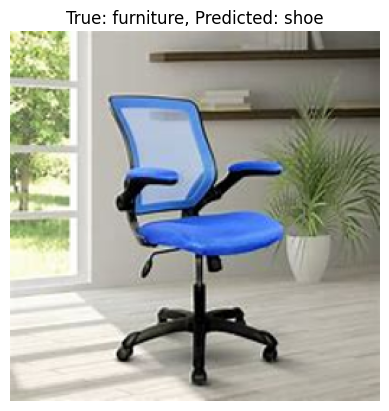

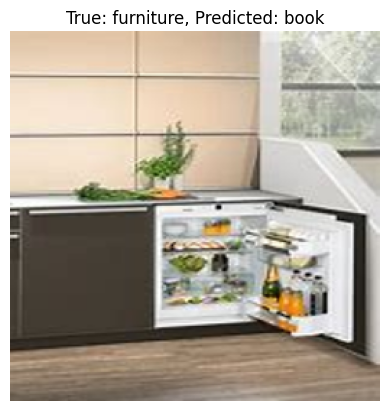

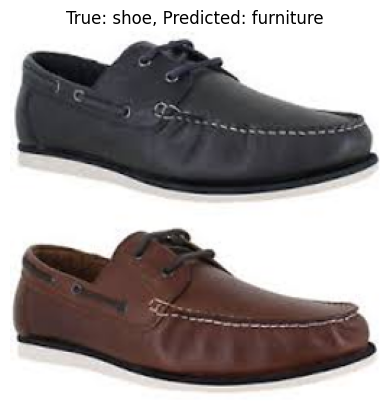

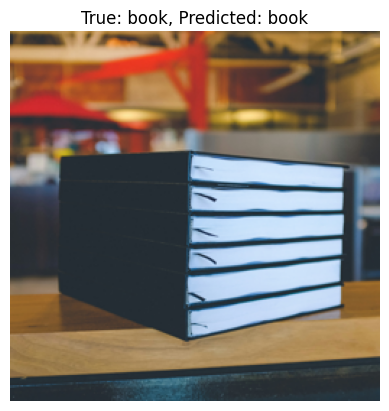

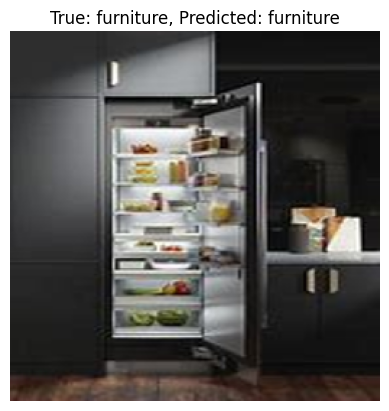

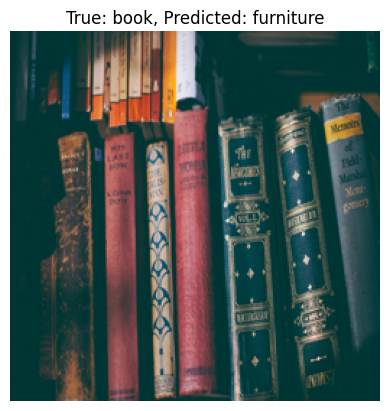

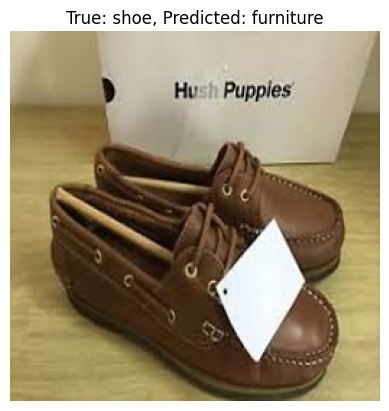

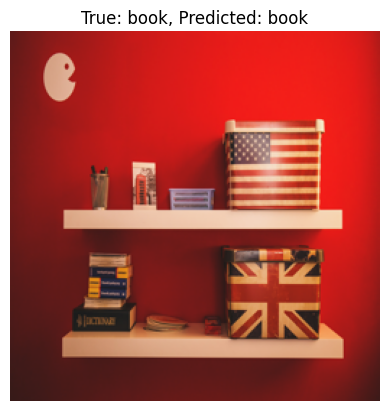

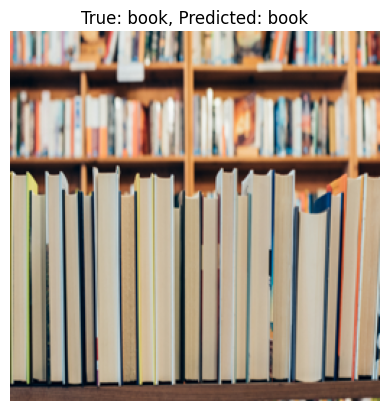

In [28]:
# Display some example images with predicted and true labels
def display_predictions(num_samples_to_show=10):
    for i in range(num_samples_to_show):
        true_label = true_labels[i]
        predicted_label = random_predictions[i]
        image = train_images[i]
        plt.imshow(image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

display_predictions()

## Baseline neural network model

In [33]:
def baseline_cnn(input_shape=(256, 256, 3), num_classes=3):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax'),
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

baseline_cnn = baseline_cnn()

# One-Hot-Encode Labels and convert Images to array for training
true_labels_categorical = to_categorical([classes.index(label) for label in true_labels], num_classes=len(classes))
train_images = np.array(train_images)

baseline_cnn.fit(train_images, true_labels_categorical, epochs=10, batch_size=16)

Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.2289 - loss: 3852.7583
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.5705 - loss: 3.0179
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.7577 - loss: 0.8320


### Evaluate Baseline CNN
#### As we can see, the baseline neural net models accuracy is around 35%, which means it's basically random guessing.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Trained Model Accuracy: 0.38



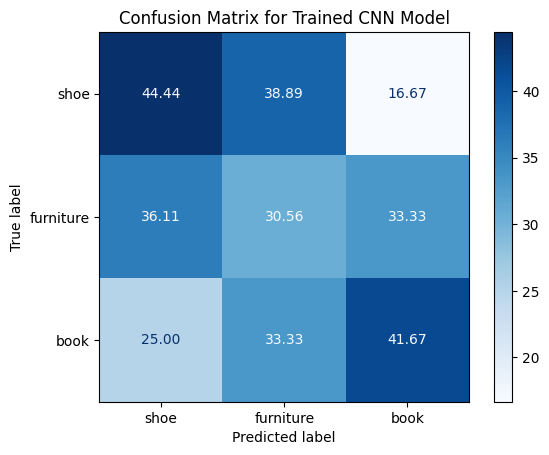

In [35]:
# Convert Images as before
test_images = np.array(test_images)

# Eval
predictions = baseline_cnn.predict(test_images)
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]

# Calculate accuracy for the trained model
trained_accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Trained Model Accuracy: {trained_accuracy:.2f}\n")

# Confusion matrix
trained_conf_matrix = confusion_matrix(test_labels, predicted_labels, labels=classes)
trained_conf_matrix_percent = np.nan_to_num(conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100)

trained_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=classes)
trained_disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title('Confusion Matrix for Trained CNN Model')
plt.show()

### Display some images with predicted and real labels

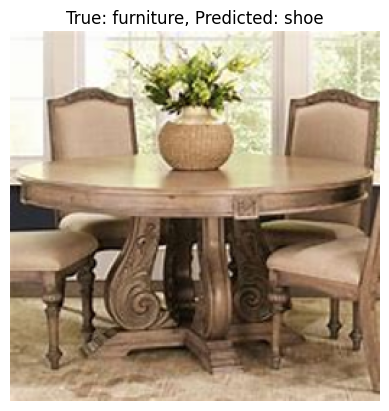

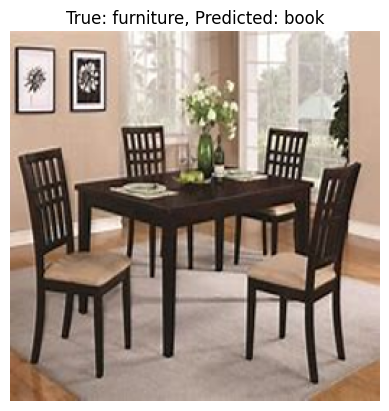

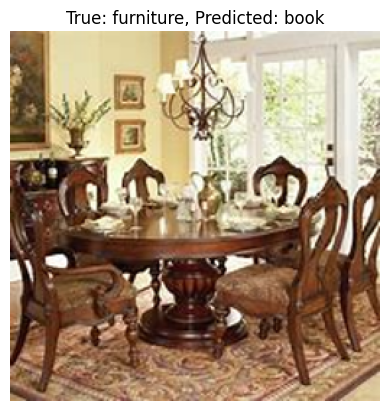

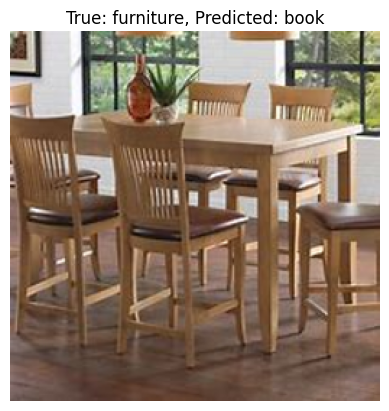

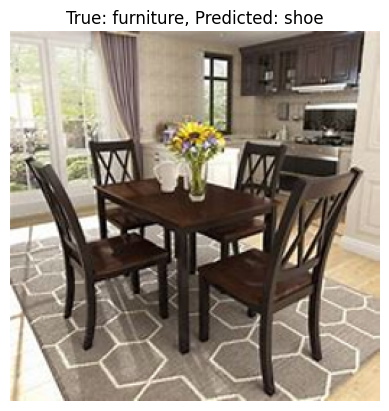

In [34]:
def display_trained_predictions(num_samples_to_show=5):
    for i in range(num_samples_to_show):
        true_label = test_labels[i]
        predicted_label = predicted_labels[i]
        image = test_images[i]
        plt.imshow(image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

display_trained_predictions()

# Iterative Neural Network Development

## Image Augmentation
### Because of the limited dataset (150 images) we used image augmentation for every model, to try to prevent overfitting and to generate more data for the models to train on. Also we included early stopping with every model, to select the best model easily.

In [7]:
def data_prep():
  datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      rescale=1.0 / 255.0)

  val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
  classes = ['book', 'furniture', 'shoe']
  batch_size = 9

  train_images_local = np.array(train_images)
  train_labels_categorical = to_categorical([classes.index(label) for label in train_labels], num_classes=len(classes))

  val_images_local = np.array(val_images)
  val_labels_categorical = to_categorical([classes.index(label) for label in val_labels], num_classes=len(classes))

  train_generator = datagen.flow(train_images_local, train_labels_categorical, batch_size=batch_size)
  val_generator = val_datagen.flow(val_images_local, val_labels_categorical, batch_size=batch_size)

  early_stopping = EarlyStopping(
      monitor='val_accuracy',
      mode='max',
      patience=7,                      # Stop as soon as the the last 5 epochs performance was worse
      restore_best_weights=True,
      baseline=0.70                    # Minimum value of val_accuracy to trigger stopping
  )

  return train_generator, val_generator, early_stopping

train_generator, val_generator, early_stopping = data_prep()

## Advanced Evaluation
### We choose Accuracy, Precision, Recall, Confusion Matrix and ROC curve to analyze the models

In [8]:
def evaluation(model, test_images, test_labels):
    classes = ['book', 'furniture', 'shoe']
    test_images = np.array(test_images)

    # Get predictions and probabilities
    predictions = model.predict(test_images)
    predicted_labels = [classes[np.argmax(pred)] for pred in predictions]

    # Accuracy, Precision, and Recall
    trained_accuracy = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels, labels=classes, average='weighted')
    recall = recall_score(test_labels, predicted_labels, labels=classes, average='weighted')
    print(f"Accuracy: {trained_accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

    # Confusion matrix
    trained_conf_matrix = confusion_matrix(test_labels, predicted_labels, labels=classes)
    trained_conf_matrix_percent = np.nan_to_num(trained_conf_matrix / trained_conf_matrix.sum(axis=1, keepdims=True) * 100)

    trained_disp = ConfusionMatrixDisplay(confusion_matrix=trained_conf_matrix_percent, display_labels=classes)
    trained_disp.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title('Confusion Matrix for Trained CNN Model')
    plt.show()

    # Bar Chart for Accuracy, Precision, and Recall
    metrics = ['Accuracy', 'Precision', 'Recall']
    values = [trained_accuracy, precision, recall]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, values)
    plt.ylim(0, 1)
    plt.title('Evaluation Metrics')
    plt.ylabel('Score')
    plt.show()

    # ROC Curve and AUC
    test_labels_one_hot = np.array([[1 if lbl == cls else 0 for cls in classes] for lbl in test_labels])
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(test_labels_one_hot[:, i], predictions[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_one_hot.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    for cls in classes:
        plt.plot(fpr[cls], tpr[cls], label=f'{cls} (AUC = {roc_auc[cls]:.2f})')
    plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', color='grey')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')

    plt.title('ROC Curve for Each Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

## Model 1
### The plan is to use a ResNet like model, because it is one of the most widely used model type for image classification. The first convolutional layer captures low-level features, followed by a max-pooling layer to reduce spatial dimensions. This is followed by residual blocks with increasing numbers of filters and downsampling at certain stages.

In [44]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save the input for the skip connection
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1: # Add skip connection
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])  # Add the shortcut connection
    x = layers.ReLU()(x)
    return x

def build_resnet(input_shape=(256, 256, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2)  # Downsample
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2)  # Downsample
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2)  # Downsample
    x = residual_block(x, filters=512)

    # Global average pooling to combat overfitting
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet(input_shape=(256, 256, 3), num_classes=3)
history = resnet_model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.4509 - loss: 3.4519 - val_accuracy: 0.3333 - val_loss: 199.0270
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.3254 - loss: 2.1948 - val_accuracy: 0.3333 - val_loss: 216.4585
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.4678 - loss: 1.2764 - val_accuracy: 0.2857 - val_loss: 37.5338
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.6182 - loss: 0.9360 - val_accuracy: 0.2857 - val_loss: 17.4313
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7228 - loss: 0.7315 - val_accuracy: 0.3333 - val_loss: 16.3622


### Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Trained Model Accuracy: 0.33


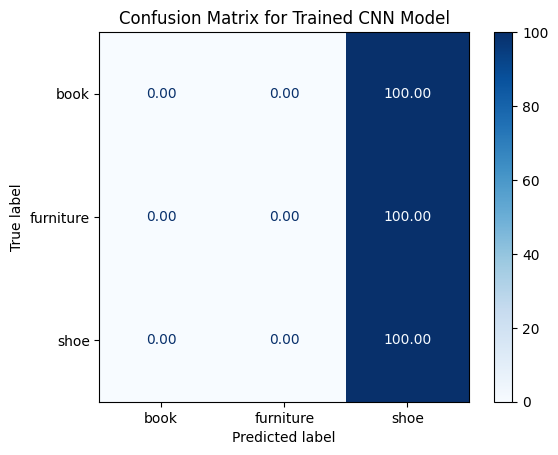

In [58]:
evaluation(resnet_model, test_images, test_labels)

# Model 2
### Simplified ResNet model. As we can see the model overfitting, so the model needs to be simplified.

In [59]:
def simple_residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save the input for the skip connection
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1: # Add skip connection
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])  # Add the shortcut connection
    x = layers.ReLU()(x)
    return x

def build_simple_resnet(input_shape=(256, 256, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = simple_residual_block(x, filters=64)
    x = simple_residual_block(x, filters=64)
    x = simple_residual_block(x, filters=128, stride=2)  # Downsample
    x = simple_residual_block(x, filters=128)

    # Global average pooling to combat overfitting
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

simple_resnet_model = build_simple_resnet(input_shape=(256, 256, 3), num_classes=3)
history = simple_resnet_model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stopping])

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4901 - loss: 1.4050 - val_accuracy: 0.3333 - val_loss: 2.9722
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.4746 - loss: 1.0842 - val_accuracy: 0.2857 - val_loss: 4.7520
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6400 - loss: 0.7953 - val_accuracy: 0.2857 - val_loss: 4.8949
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.6028 - loss: 0.8607 - val_accuracy: 0.2857 - val_loss: 1.6703
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6481 - loss: 0.7427 - val_accuracy: 0.2857 - val_loss: 2.3117


### Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Trained Model Accuracy: 0.33


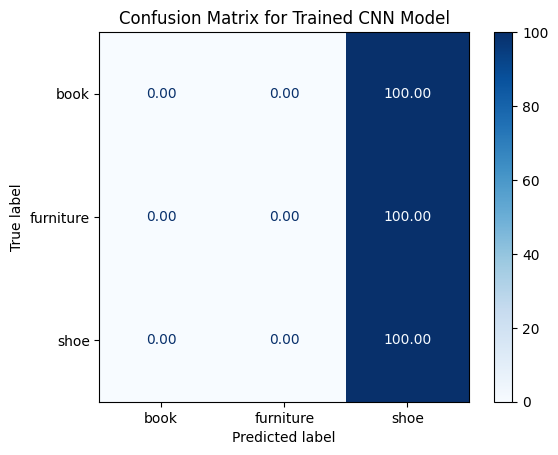

In [60]:
evaluation(simple_resnet_model, test_images, test_labels)

# Model 3
### Simplifie the ResNet model even further, to try to combat overfitting.

In [61]:
def simple_2_residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save the input for the skip connection
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1: # Add skip connection
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])  # Add the shortcut connection
    x = layers.ReLU()(x)
    return x

def build_simple_2_resnet(input_shape=(256, 256, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = simple_2_residual_block(x, filters=64, stride=2)
    x = simple_2_residual_block(x, filters=64, stride=2)

    # Global average pooling to combat overfitting
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

simple_2_resnet_model = build_simple_2_resnet(input_shape=(256, 256, 3), num_classes=3)
history = simple_2_resnet_model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stopping])

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 840ms/step - accuracy: 0.4166 - loss: 1.1081 - val_accuracy: 0.3333 - val_loss: 1.5496
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5742 - loss: 0.9102 - val_accuracy: 0.2857 - val_loss: 1.6832
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 904ms/step - accuracy: 0.6103 - loss: 0.8425 - val_accuracy: 0.2857 - val_loss: 1.4388
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5606 - loss: 0.8295 - val_accuracy: 0.2857 - val_loss: 1.6476
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6832 - loss: 0.7234 - val_accuracy: 0.2857 - val_loss: 1.7471


### Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Trained Model Accuracy: 0.33


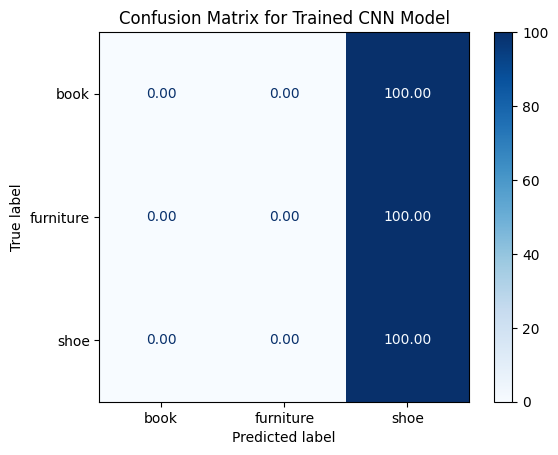

In [62]:
evaluation(simple_2_resnet_model, test_images, test_labels)

# Model 4
### Final model. We decided to change approach. It seemed the ResNet model is not suited well enough for such a small dataset and could not be simpliefied enough to stop overfitting on the data. Because of this we decided to try a really simple CNN that had only a few layers and no special connection between them.
### After a few tries we saw that the model was predicting false positives for the furniture class, most likely caused by the resemblance with books class, so we lowered the weight of furniture by half.

In [12]:
unique_classes = np.unique(train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_labels
)

# Decrease weight of furniture class by half
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict[2] *= 0.6
class_weights_dict[1] *= 0.5

checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

def create_improved_cnn(input_shape=(256, 256, 3), num_classes=3):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

improved_cnn_model = create_improved_cnn()
history = improved_cnn_model.fit(train_generator, validation_data=val_generator, epochs=20,
                                 class_weight=class_weights_dict, callbacks=[checkpoint_callback])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.3076 - loss: 1.2694
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 869ms/step - accuracy: 0.3075 - loss: 1.2564 - val_accuracy: 0.3333 - val_loss: 1.1851
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.3410 - loss: 0.7604
Epoch 2: val_accuracy did not improve from 0.33333
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 684ms/step - accuracy: 0.3404 - loss: 0.7603 - val_accuracy: 0.3333 - val_loss: 1.0914
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.4025 - loss: 0.7687
Epoch 3: val_accuracy did not improve from 0.33333
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 832ms/step - accuracy: 0.3971 - loss: 0.7674 - val_accuracy: 0.3333 - val_loss: 1.0928
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.3139 - loss: 0.6909
Epoch 4: val_accuracy did not improve from 0.33333
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 642ms/step - accuracy: 0.3176 - l

### Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Accuracy: 0.67
Precision: 0.78
Recall: 0.67



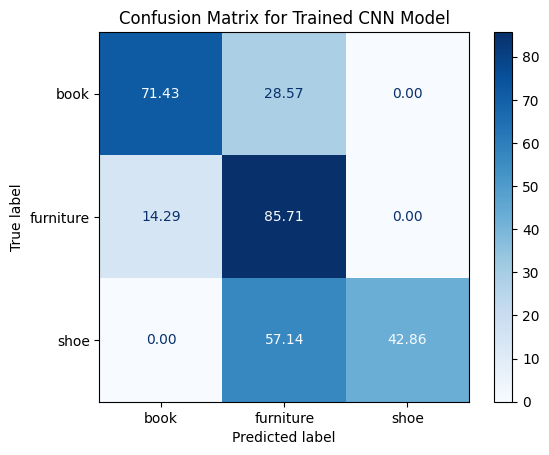

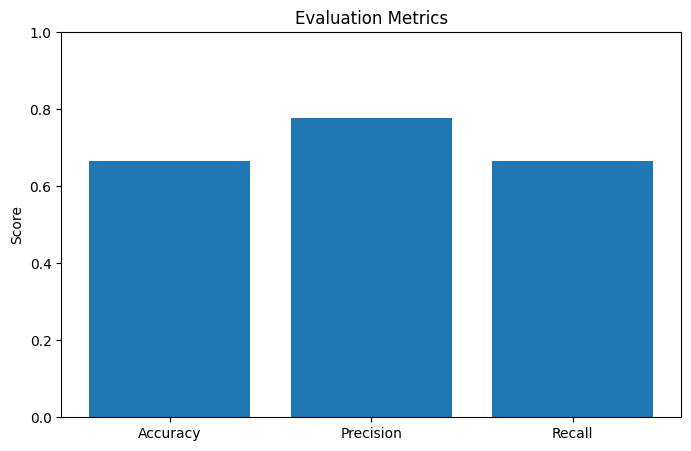

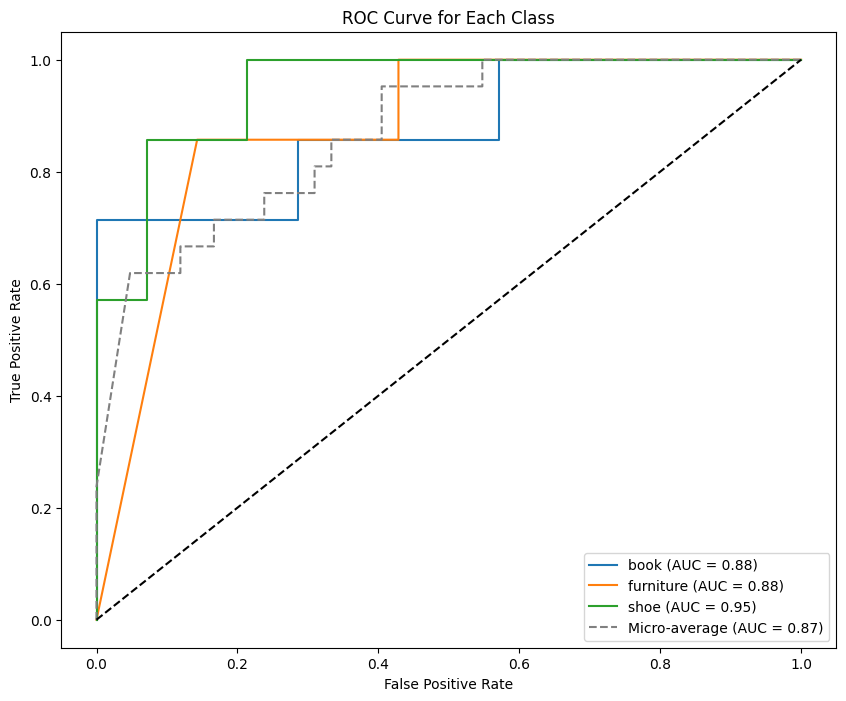

In [13]:
evaluation(improved_cnn_model, test_images, test_labels)

# Best Version of Model 4

In [ ]:
# Követelmények

# Data acquisition and analysis - DONE
# Data cleansing and preparation - DONE
# Baseline (reference) model - DONE
# Visualization in Jupyter notebook if justified - DONE
# Incremental model development - DONE
# README.md with the team name, team member names and Neptun code, how to run the training and evaluation. - DONE
# Advanced evaluation - DONE

# Defining evaluation criteria - TODO
# Well-annotated source code uploaded to GitHub.com - TODO
# ML as a service (prototype) grad.io - TODO
# Containerization - NEEDS TESTING

# Documentation (min 2, max 8 pages) in a separate PDF file (uploaded to Github as well).
#   Intro about the chosen topic (including relevant scientific papers)
#   Methods of training (type of neural network chosen, design choices, manual and/or automatic hyperparameter optimization
#   References to the methods in scientific papers, what were applied)
#   # Document LLMs Usage (code-, comment-, text-generation, text correction, style correction...). Always check the output.
#   Evaluation (results on test data, including visualization), and Conclusions (what is the main result of your project).

# The grading: correctness of the solution from a theoretical and practical point of view.
# Bonus points for good model.
# You will have to present the project work during the exam in 5-8 minutes.